In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/vibe/raw_data/twitter_MBTI.csv')

In [64]:
df = df[['text', 'label']]  # Keep only what's necessary
df.dropna(inplace=True)     # Drop rows with missing values

In [65]:
# Create one binary column for each MBTI letter
df['IE'] = df['label'].apply(lambda x: 1 if x[0] == 'i' else 0)
df['NS'] = df['label'].apply(lambda x: 1 if x[1] == 'n' else 0)
df['TF'] = df['label'].apply(lambda x: 1 if x[2] == 't' else 0)
df['JP'] = df['label'].apply(lambda x: 1 if x[3] == 'j' else 0)

In [66]:
import re

def clean_posts(text):
    # Sépare les tweets si concaténés par ||||
    tweets = text.split("||||")

    cleaned = []
    for tweet in tweets:
        # Supprime les mentions @utilisateur
        tweet = re.sub(r'@\w+', '', tweet)
        # Supprime les liens
        tweet = re.sub(r'http\S+', '', tweet)
        # Supprime les caractères non alphabétiques (en gardant les espaces)
        tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
        # Met en minuscules
        tweet = tweet.lower()
        # Supprime les espaces multiples
        tweet = re.sub(r'\s+', ' ', tweet).strip()
        cleaned.append(tweet)

    # Rejoint les tweets nettoyés en une seule chaîne
    return " ".join(cleaned)

In [67]:
df['clean_text'] = df['text'].apply(clean_posts)

In [68]:
df.head()

,text,label,IE,NS,TF,JP,clean_text
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj,1,1,1,1,the pope is infallible this is a catholic dogm...
1,@Hispanthicckk Being you makes you look cute||...,intj,1,1,1,1,being you makes you look cute on because then ...
2,@Alshymi Les balles sont réelles et sont tirée...,intj,1,1,1,1,les balles sont relles et sont tires trs rapid...
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj,1,1,1,1,im like entp but idiotichey boy do you want to...
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj,1,1,1,1,give it to he has pica since childhood say qub...


In [69]:
print(f"balance of the target ie : {df['IE'].value_counts(normalize=True)}")
print(f"balance of the target ns :{df['NS'].value_counts(normalize=True)}")
print(f"balance of the target tf :{df['TF'].value_counts(normalize=True)}")
print(f"balance of the target jp :{df['JP'].value_counts(normalize=True)}")

balance of the target ie : IE
1    0.671873
0    0.328127
Name: proportion, dtype: float64
balance of the target ns :NS
1    0.7725
0    0.2275
Name: proportion, dtype: float64
balance of the target tf :TF
0    0.588401
1    0.411599
Name: proportion, dtype: float64
balance of the target jp :JP
0    0.559083
1    0.440917
Name: proportion, dtype: float64


In [70]:
df['text_length_words'] = df['clean_text'].str.split().apply(len)

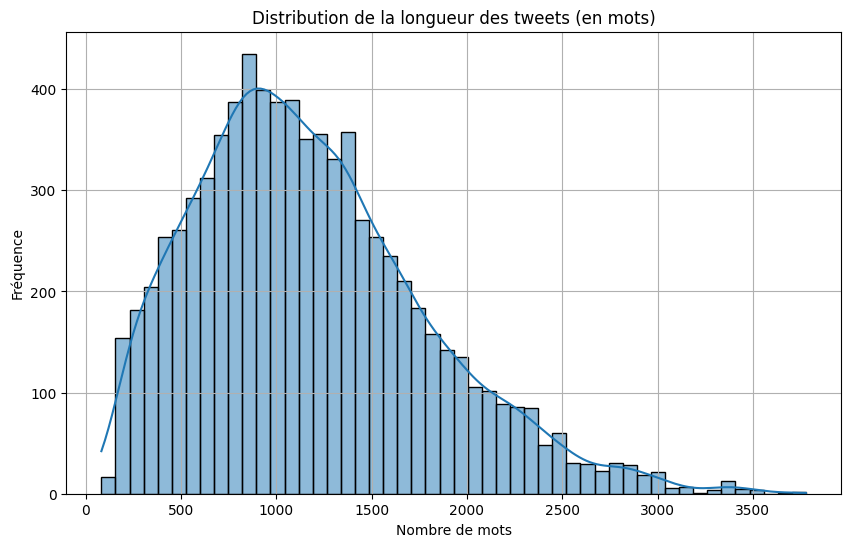

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length_words'], bins=50, kde=True)
plt.title("Distribution de la longueur des tweets (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

In [72]:
df = df[df['clean_text'].apply(lambda x: len(x.split()) < 1500 and len(x.split()) > 500)].reset_index(drop=True)

In [73]:
df.describe()

,IE,NS,TF,JP,text_length_words
count,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000
mean,0.664428,0.762434,0.405666,0.416999,996.609024
std,0.472240,0.425636,0.491072,0.493114,273.101713
min,0.000000,0.000000,0.000000,0.000000,501.000000
25%,0.000000,1.000000,0.000000,0.000000,774.000000
50%,1.000000,1.000000,0.000000,0.000000,989.000000
75%,1.000000,1.000000,1.000000,1.000000,1225.000000
max,1.000000,1.000000,1.000000,1.000000,1499.000000


In [74]:
df.head()

,text,label,IE,NS,TF,JP,clean_text,text_length_words
0,@Hispanthicckk Being you makes you look cute||...,intj,1,1,1,1,being you makes you look cute on because then ...,884
1,"I'm like entp but idiotic|||Hey boy, do you wa...",intj,1,1,1,1,im like entp but idiotichey boy do you want to...,916
2,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj,1,1,1,1,give it to he has pica since childhood say qub...,823
3,proud of this one it goes hard https://t.co/RQ...,intj,1,1,1,1,proud of this one it goes hard disgusting i am...,591
4,@Ieokuras so amazing!|||@hxhrats @ETTUKILLUG w...,intj,1,1,1,1,so amazing well mozart was a composer togashi ...,904


In [75]:
!pip install xgboost

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [77]:
custom_stopwords = {
    "intj", "intp", "entj", "entp",
    "infj", "infp", "enfj", "enfp",
    "istj", "isfj", "estj", "esfj",
    "istp", "isfp", "estp", "esfp", "https"
}

# Fusionner avec les stopwords anglais
combined_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))

vectorizer = TfidfVectorizer(max_features=20000,
                             ngram_range=(1, 2),
                             stop_words=combined_stopwords)

X = vectorizer.fit_transform(df["text"])

In [78]:
y_tf = df["TF"]
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X, y_tf, test_size=0.2, random_state=42)
model_tf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_tf.fit(X_train_tf, y_train_tf)
y_pred_tf = model_tf.predict(X_test_tf)
print(classification_report(y_test_tf, y_pred_tf))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:55:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.65      0.79      0.71       562
           1       0.56      0.38      0.45       391

    accuracy                           0.62       953
   macro avg       0.60      0.59      0.58       953
weighted avg       0.61      0.62      0.61       953



In [79]:
# Get feature importances
importances_tf = model_tf.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_tf = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_tf = list(zip(feature_names_tf, importances_tf))

# Sort by importance
word_importances_tf = sorted(word_importances_tf, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_tf[:20]:
    print(f"{word}: {importance:.4f}")

kim: 0.0055
apparently: 0.0046
england: 0.0041
gt lt: 0.0039
nvm: 0.0037
comeback: 0.0037
yeonjun: 0.0037
crisis: 0.0035
evil: 0.0034
simple: 0.0033
bitches: 0.0033
sooo: 0.0033
remind: 0.0032
heyy: 0.0032
wake: 0.0032
hahah: 0.0031
abt: 0.0031
ng: 0.0031
just dont: 0.0031
cooking: 0.0031


In [80]:
y_ie = df["IE"]
X_train_ie, X_test_ie, y_train_ie, y_test_ie = train_test_split(X, y_ie, test_size=0.2, random_state=42)
model_ie = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_ie.fit(X_train_ie, y_train_ie)
y_pred_ie = model_ie.predict(X_test_ie)
print(classification_report(y_test_ie, y_pred_ie))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:55:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.47      0.25      0.32       313
           1       0.70      0.86      0.77       640

    accuracy                           0.66       953
   macro avg       0.58      0.55      0.55       953
weighted avg       0.62      0.66      0.63       953



In [81]:
# Get feature importances
importances_ie = model_ie.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_ie = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_ie = list(zip(feature_names_ie, importances_ie))

# Sort by importance
word_importances_ie = sorted(word_importances_ie, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_ie[:20]:
    print(f"{word}: {importance:.4f}")

car: 0.0056
does know: 0.0051
ur: 0.0048
process: 0.0047
fell love: 0.0045
sex: 0.0044
florida: 0.0041
angst: 0.0038
beat: 0.0034
context: 0.0033
inspiring: 0.0032
ve listening: 0.0032
fashion: 0.0032
small: 0.0032
youu: 0.0032
ended: 0.0031
80: 0.0031
36: 0.0031
bark: 0.0030
knowledge: 0.0030


In [82]:
y_ns = df["NS"]
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X, y_ns, test_size=0.2, random_state=42)
model_ns = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_ns.fit(X_train_ns, y_train_ns)
y_pred_ns = model_ns.predict(X_test_ns)
print(classification_report(y_test_ns, y_pred_ns))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:55:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.46      0.11      0.17       214
           1       0.79      0.96      0.87       739

    accuracy                           0.77       953
   macro avg       0.62      0.54      0.52       953
weighted avg       0.71      0.77      0.71       953



In [83]:
# Get feature importances
importances_ns = model_ns.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_ns = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_ns = list(zip(feature_names_ns, importances_ns))

# Sort by importance
word_importances_ns = sorted(word_importances_ns, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_ns[:20]:
    print(f"{word}: {importance:.4f}")

right right: 0.0065
cheers: 0.0054
im getting: 0.0053
kilala: 0.0050
piercing: 0.0050
women: 0.0046
violent: 0.0044
makes wanna: 0.0043
planning: 0.0043
dance practice: 0.0042
tyy: 0.0042
lrt: 0.0042
kong: 0.0042
feel sick: 0.0041
enhypen_members: 0.0040
14: 0.0039
supposed: 0.0038
thx: 0.0038
slayed: 0.0037
concept: 0.0037


In [84]:
y = df["NS"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Dealing with class imbalanced
num_pos = sum(y_train)
num_neg = len(y_train) - num_pos
scale = num_neg / num_pos

model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale  # 👈 Boosts minority class
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:56:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.38      0.23      0.29       214
           1       0.80      0.89      0.84       739

    accuracy                           0.74       953
   macro avg       0.59      0.56      0.57       953
weighted avg       0.71      0.74      0.72       953



In [85]:
y_jp = df["JP"]
X_train_jp, X_test_jp, y_train_jp, y_test_jp = train_test_split(X, y_jp, test_size=0.2, random_state=42)
model_jp = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_jp.fit(X_train_jp, y_train_jp)
y_pred_jp = model_jp.predict(X_test_jp)
print(classification_report(y_test_jp, y_pred_jp))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:56:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.61      0.78      0.69       532
           1       0.57      0.38      0.46       421

    accuracy                           0.60       953
   macro avg       0.59      0.58      0.57       953
weighted avg       0.60      0.60      0.58       953



In [86]:
# Get feature importances
importances_jp = model_ns.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_jp = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_jp = list(zip(feature_names_jp, importances_jp))

# Sort by importance
word_importances_jp = sorted(word_importances_jp, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_jp[:20]:
    print(f"{word}: {importance:.4f}")

right right: 0.0065
cheers: 0.0054
im getting: 0.0053
kilala: 0.0050
piercing: 0.0050
women: 0.0046
violent: 0.0044
makes wanna: 0.0043
planning: 0.0043
dance practice: 0.0042
tyy: 0.0042
lrt: 0.0042
kong: 0.0042
feel sick: 0.0041
enhypen_members: 0.0040
14: 0.0039
supposed: 0.0038
thx: 0.0038
slayed: 0.0037
concept: 0.0037


In [87]:
custom_stopwords = [
    "intj", "intp", "entj", "entp",
    "infj", "infp", "enfj", "enfp",
    "istj", "isfj", "estj", "esfj",
    "istp", "isfp", "estp", "esfp"
]

vectorizer = TfidfVectorizer(max_features=20000,
                             ngram_range=(1, 3),
                             stop_words=custom_stopwords)

X = vectorizer.fit_transform(df["text"])

In [88]:
y_jp = df["JP"]
X_train_jp, X_test_jp, y_train_jp, y_test_jp = train_test_split(X, y_jp, test_size=0.2, random_state=42)
model_jp = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_jp.fit(X_train_jp, y_train_jp)
y_pred_jp = model_jp.predict(X_test_jp)
print(classification_report(y_test_jp, y_pred_jp))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:57:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.61      0.78      0.68       532
           1       0.57      0.37      0.45       421

    accuracy                           0.60       953
   macro avg       0.59      0.57      0.57       953
weighted avg       0.59      0.60      0.58       953



In [89]:
# Get feature importances
importances_jp = model_ns.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_jp = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_jp = list(zip(feature_names_jp, importances_jp))

# Sort by importance
word_importances_jp = sorted(word_importances_jp, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_jp[:20]:
    print(f"{word}: {importance:.4f}")

so silly: 0.0065
category: 0.0054
it been years: 0.0053
like two: 0.0050
releases: 0.0050
work but: 0.0046
well that: 0.0044
my spotify: 0.0043
respectfully: 0.0043
designed: 0.0042
volunteer: 0.0042
my cats: 0.0042
long https: 0.0042
gain: 0.0041
first https co: 0.0040
2022 https co: 0.0039
this now: 0.0038
tpwk_11: 0.0038
the: 0.0037
concept: 0.0037


In [90]:
ie_pred = ['i' if x == 1 else 'e' for x in y_pred_ie]
ns_pred = ['n' if x == 1 else 's' for x in y_pred_ns]
tf_pred = ['t' if x == 1 else 'f' for x in y_pred_tf]
jp_pred = ['j' if x == 1 else 'p' for x in y_pred_jp]

y_test_ie_l = ['i' if x == 1 else 'e' for x in y_test_ie]
y_test_ns_l = ['n' if x == 1 else 's' for x in y_test_ns]
y_test_tf_l = ['t' if x == 1 else 'f' for x in y_test_tf]
y_test_jp_l = ['j' if x == 1 else 'p' for x in y_test_jp]

In [91]:
# Create DataFrame
df_pred = pd.DataFrame({
    'IE': ie_pred,
    'NS': ns_pred,
    'TF': tf_pred,
    'JP': jp_pred,
    'IE_test': y_test_ie_l,
    'NS_test': y_test_ns_l,
    'TF_test': y_test_tf_l,
    'JP_test': y_test_jp_l
})

df_pred['MBTI'] = df_pred['IE'] + df_pred['NS'] + df_pred['TF'] + df_pred['JP']
df_pred['MBTI_test'] = df_pred['IE_test'] + df_pred['NS_test'] + df_pred['TF_test'] + df_pred['JP_test']

In [92]:
df_pred

,IE,NS,TF,JP,IE_test,NS_test,TF_test,JP_test,MBTI,MBTI_test
0,i,n,t,p,e,n,t,p,intp,entp
1,e,n,f,p,i,n,t,p,enfp,intp
2,i,n,f,p,i,n,t,p,infp,intp
3,i,n,t,j,i,n,t,j,intj,intj
4,i,n,t,p,i,n,t,p,intp,intp
...,...,...,...,...,...,...,...,...,...,...
948,e,n,t,p,e,n,t,p,entp,entp
949,i,n,f,p,i,s,f,p,infp,isfp
950,i,n,t,p,i,n,f,p,intp,infp
951,e,n,f,p,e,n,f,j,enfp,enfj


In [93]:
accuracy = (df_pred['MBTI'] == df_pred['MBTI_test']).mean() * 100

print(f"Pourcentage de MBTI correctement prédits : {accuracy:.2f}%")

Pourcentage de MBTI correctement prédits : 20.04%


In [94]:
accuracy_ie = (df_pred['IE'] == df_pred['IE_test']).mean() * 100
accuracy_ns = (df_pred['NS'] == df_pred['NS_test']).mean() * 100
accuracy_tf = (df_pred['TF'] == df_pred['TF_test']).mean() * 100
accuracy_jp = (df_pred['JP'] == df_pred['JP_test']).mean() * 100


print(f"Pourcentage de IE correctement prédits : {accuracy_ie:.2f}%")
print(f"Pourcentage de NS correctement prédits : {accuracy_ns:.2f}%")
print(f"Pourcentage de TF correctement prédits : {accuracy_tf:.2f}%")
print(f"Pourcentage de JP correctement prédits : {accuracy_jp:.2f}%")

Pourcentage de IE correctement prédits : 66.00%
Pourcentage de NS correctement prédits : 77.12%
Pourcentage de TF correctement prédits : 62.33%
Pourcentage de JP correctement prédits : 59.81%


In [95]:
df_last_model = pd.DataFrame({
        'IE': y_pred_ie,
        'NS': y_pred_ns,
        'TF': y_pred_tf,
        'JP': y_pred_jp,
        'IE_test': y_test_ie,
        'NS_test': y_test_ns,
        'TF_test': y_test_tf,
        'JP_test': y_test_jp
    })

In [96]:
df_last_model

,IE,NS,TF,JP,IE_test,NS_test,TF_test,JP_test
964,1,1,1,0,0,1,1,0
3355,0,1,0,0,1,1,1,0
2596,1,1,0,0,1,1,1,0
3961,1,1,1,1,1,1,1,1
598,1,1,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...
1041,0,1,1,0,0,1,1,0
2574,1,1,0,0,1,0,0,0
3686,1,1,1,0,1,1,0,0
113,0,1,0,0,0,1,0,1


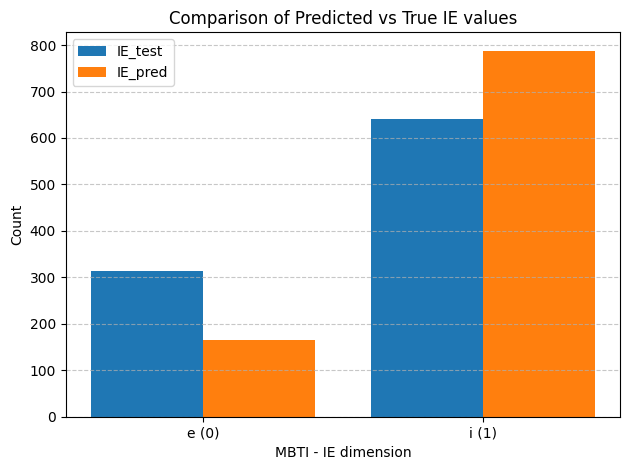

In [104]:
# Count the values of 0 and 1 for prediction and true labels
ie_pred_counts = df_last_model['IE'].value_counts().sort_index()
ie_test_counts = df_last_model['IE_test'].value_counts().sort_index()

# Define labels
labels = ['e (0)', 'i (1)']
x = range(len(labels))

# Bar plot side by side
plt.bar([i - 0.2 for i in x], [ie_test_counts.get(i, 0) for i in range(2)], width=0.4, label='IE_test')
plt.bar([i + 0.2 for i in x], [ie_pred_counts.get(i, 0) for i in range(2)], width=0.4, label='IE_pred')

plt.xticks(x, labels)
plt.xlabel('MBTI - IE dimension')
plt.ylabel('Count')
plt.title('Comparison of Predicted vs True IE values')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

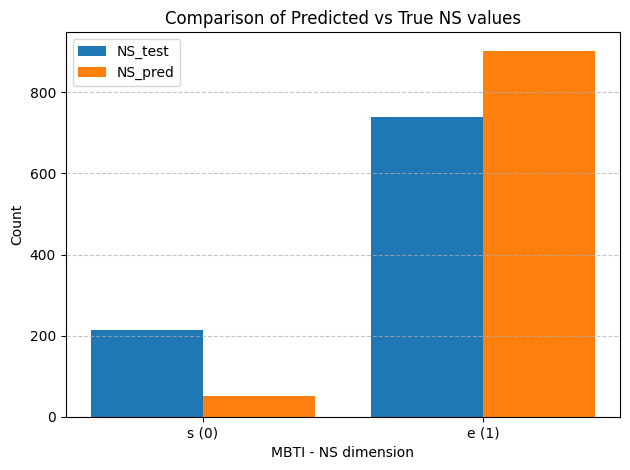

In [106]:
# Count the values of 0 and 1 for prediction and true labels
ns_pred_counts = df_last_model['NS'].value_counts().sort_index()
ns_test_counts = df_last_model['NS_test'].value_counts().sort_index()

# Define labels
labels = ['s (0)', 'e (1)']
x = range(len(labels))

# Bar plot side by side
plt.bar([i - 0.2 for i in x], [ns_test_counts.get(i, 0) for i in range(2)], width=0.4, label='NS_test')
plt.bar([i + 0.2 for i in x], [ns_pred_counts.get(i, 0) for i in range(2)], width=0.4, label='NS_pred')

plt.xticks(x, labels)
plt.xlabel('MBTI - NS dimension')
plt.ylabel('Count')
plt.title('Comparison of Predicted vs True NS values')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

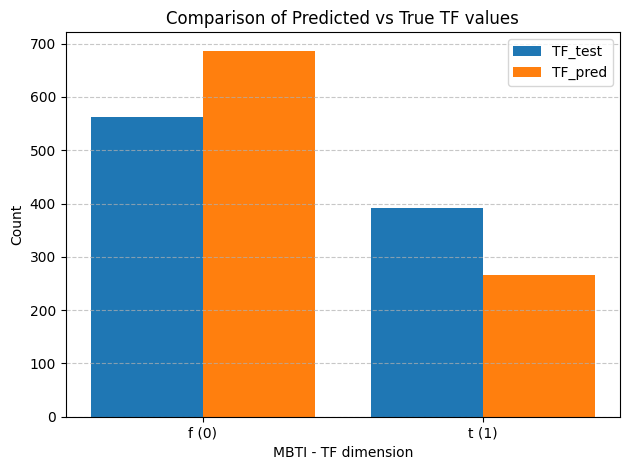

In [107]:
# Count the values of 0 and 1 for prediction and true labels
tf_pred_counts = df_last_model['TF'].value_counts().sort_index()
tf_test_counts = df_last_model['TF_test'].value_counts().sort_index()

# Define labels
labels = ['f (0)', 't (1)']
x = range(len(labels))

# Bar plot side by side
plt.bar([i - 0.2 for i in x], [tf_test_counts.get(i, 0) for i in range(2)], width=0.4, label='TF_test')
plt.bar([i + 0.2 for i in x], [tf_pred_counts.get(i, 0) for i in range(2)], width=0.4, label='TF_pred')

plt.xticks(x, labels)
plt.xlabel('MBTI - TF dimension')
plt.ylabel('Count')
plt.title('Comparison of Predicted vs True TF values')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

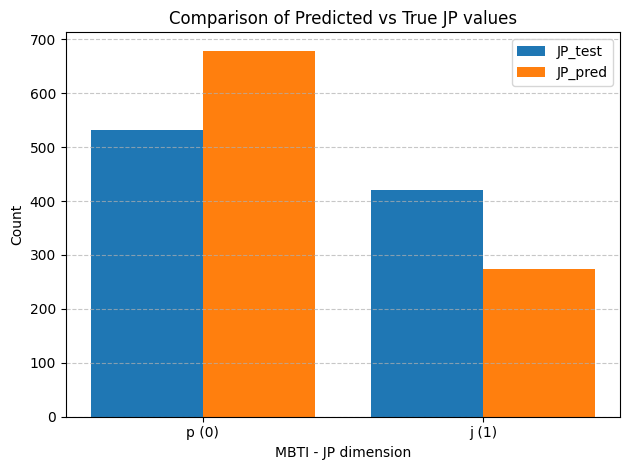

In [108]:
# Count the values of 0 and 1 for prediction and true labels
jp_pred_counts = df_last_model['JP'].value_counts().sort_index()
jp_test_counts = df_last_model['JP_test'].value_counts().sort_index()

# Define labels
labels = ['p (0)', 'j (1)']
x = range(len(labels))

# Bar plot side by side
plt.bar([i - 0.2 for i in x], [jp_test_counts.get(i, 0) for i in range(2)], width=0.4, label='JP_test')
plt.bar([i + 0.2 for i in x], [jp_pred_counts.get(i, 0) for i in range(2)], width=0.4, label='JP_pred')

plt.xticks(x, labels)
plt.xlabel('MBTI - JP dimension')
plt.ylabel('Count')
plt.title('Comparison of Predicted vs True JP values')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()